<a href="https://colab.research.google.com/github/michellecxy015/sentiment-analysis-of-lyrics/blob/main/code/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [22]:

# Load data
df_combined = pd.read_csv('/content/labeled.csv')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

def preprocess_lyrics(lyric):
    tokens = lyric.split()  # Simple split instead of word_tokenize
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)


# Apply preprocessing function to the lyrics column
df_combined['processed_text'] = df_combined['lyrics'].apply(preprocess_lyrics)

# Tokenize and pad sequences
max_words = 10000  # Vocabulary size
max_len = 100  # Maximum length of each sequence
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_combined['processed_text'])
sequences = tokenizer.texts_to_sequences(df_combined['processed_text'])
X = pad_sequences(sequences, maxlen=max_len)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Create a new column for encoded labels, so original data remains untouched
df_combined['label_encoded'] = label_encoder.fit_transform(df_combined['label'])

# Use this new column for training
labels = df_combined['label_encoded'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
# Load GloVe embeddings
embedding_dim = 100
embedding_index = {}
glove_path = '/content/glove.6B.100d.txt'

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coef

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector



Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

Epoch 1 F1 Score: 0.1336
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.2270 - loss: 1.8766 - val_accuracy: 0.2976 - val_loss: 1.7190 - learning_rate: 2.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Epoch 2 F1 Score: 0.1336
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.2598 - loss: 1.7707 - val_accuracy: 0.2976 - val_loss: 1.7086 - learning_rate: 2.0000e-04
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Epoch 3 F1 Score: 0.1446
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.2755 - loss: 1.7498 - val_accuracy: 0.3110 - val_loss: 1.6912 - learning_rate: 2.0000e-04
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

Epoch 4 F1 Score: 0.2150
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.2997 - loss: 1.7268 - val_accuracy: 0.3458 - val_loss: 1.6787 - learning_rate: 2.0000e-04
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Epoch 5 F1 Score: 0.2026
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - a

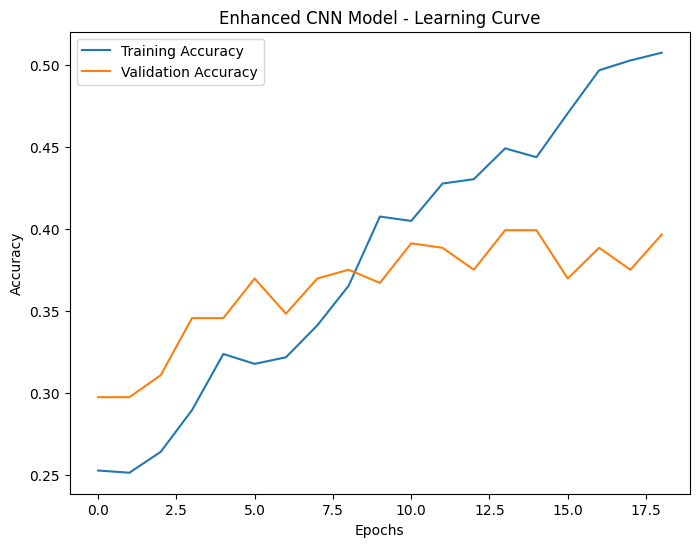

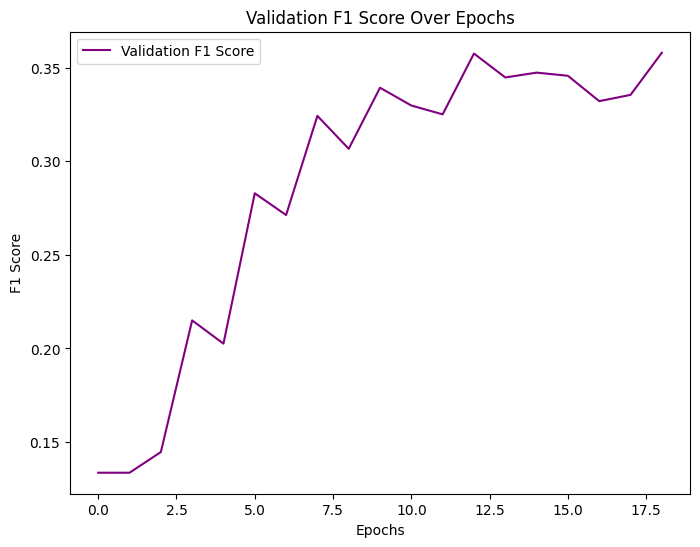

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


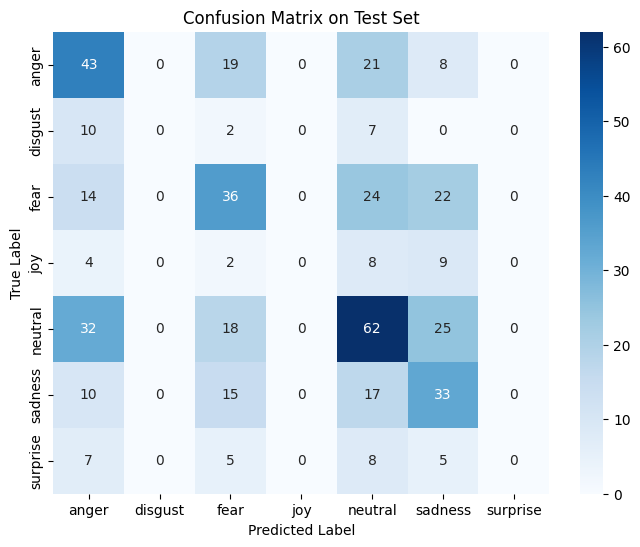

Final F1 Score on Test Set: 0.3448


In [23]:

# Define the model architecture
def create_enhanced_model():
    input_layer = Input(shape=(max_len,))

    # Embedding layer with pre-trained GloVe embeddings
    embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim,
                                weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

    # Additional Bidirectional LSTM layer for capturing sequential information
    lstm_layer = Bidirectional(LSTM(32, return_sequences=True))(embedding_layer)

    # Increased filter size and added another Conv1D layer for more complex feature extraction
    conv_1 = Conv1D(128, 3, activation='relu')(lstm_layer)
    conv_2 = Conv1D(64, 5, activation='relu')(conv_1)

    # Pooling layer to reduce dimensionality
    pooled_output = GlobalMaxPooling1D()(conv_2)

    # Dropout and dense layers
    dropout_layer = Dropout(0.3)(pooled_output)  # Reduced dropout rate to 0.3
    dense_layer = Dense(64, activation='relu')(dropout_layer)
    dropout_layer_2 = Dropout(0.3)(dense_layer)
    output_layer = Dense(len(np.unique(labels)), activation='softmax')(dropout_layer_2)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Custom callback to calculate F1 score after each epoch
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = np.argmax(self.model.predict(X_val), axis=1)
        f1 = f1_score(y_val, y_pred, average='weighted')
        self.f1_scores.append(f1)
        print(f"\nEpoch {epoch + 1} F1 Score: {f1:.4f}")

# Create and train the enhanced model
enhanced_model = create_enhanced_model()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Initialize the custom F1 score callback
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))

# Train the model
history = enhanced_model.fit(
    X_train, y_train,
    epochs=30,  # Allow more epochs to see long-term performance
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, f1_callback],
    verbose=1
)

# Plot the learning curve for accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Enhanced CNN Model - Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot the F1 score over epochs
plt.figure(figsize=(8, 6))
plt.plot(f1_callback.f1_scores, label="Validation F1 Score", color='purple')
plt.title("Validation F1 Score Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# Predict on the test set
y_pred = np.argmax(enhanced_model.predict(X_test), axis=1)

# Compute confusion matrix
label_names = label_encoder.classes_  # Use original label names
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a DataFrame for the confusion matrix for better visualization
confusion_df = pd.DataFrame(confusion_mat, index=label_names, columns=label_names)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
# Calculate the F1 score on the test set
final_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Final F1 Score on Test Set: {final_f1_score:.4f}")

In [24]:
# Calculate the F1 score on the test set
final_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Final F1 Score on Test Set: {final_f1_score:.4f}")

Final F1 Score on Test Set: 0.3448


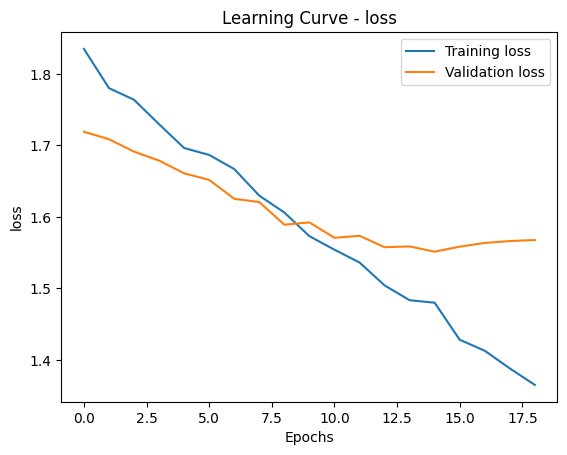

In [25]:

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Learning Curve - loss')
plt.legend()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100, 64)             │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 98, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 94, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_10              │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,313,175 (5.01 MB)

 Trainable params: 104,391 (407.78 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 208,784 (815.57 KB)

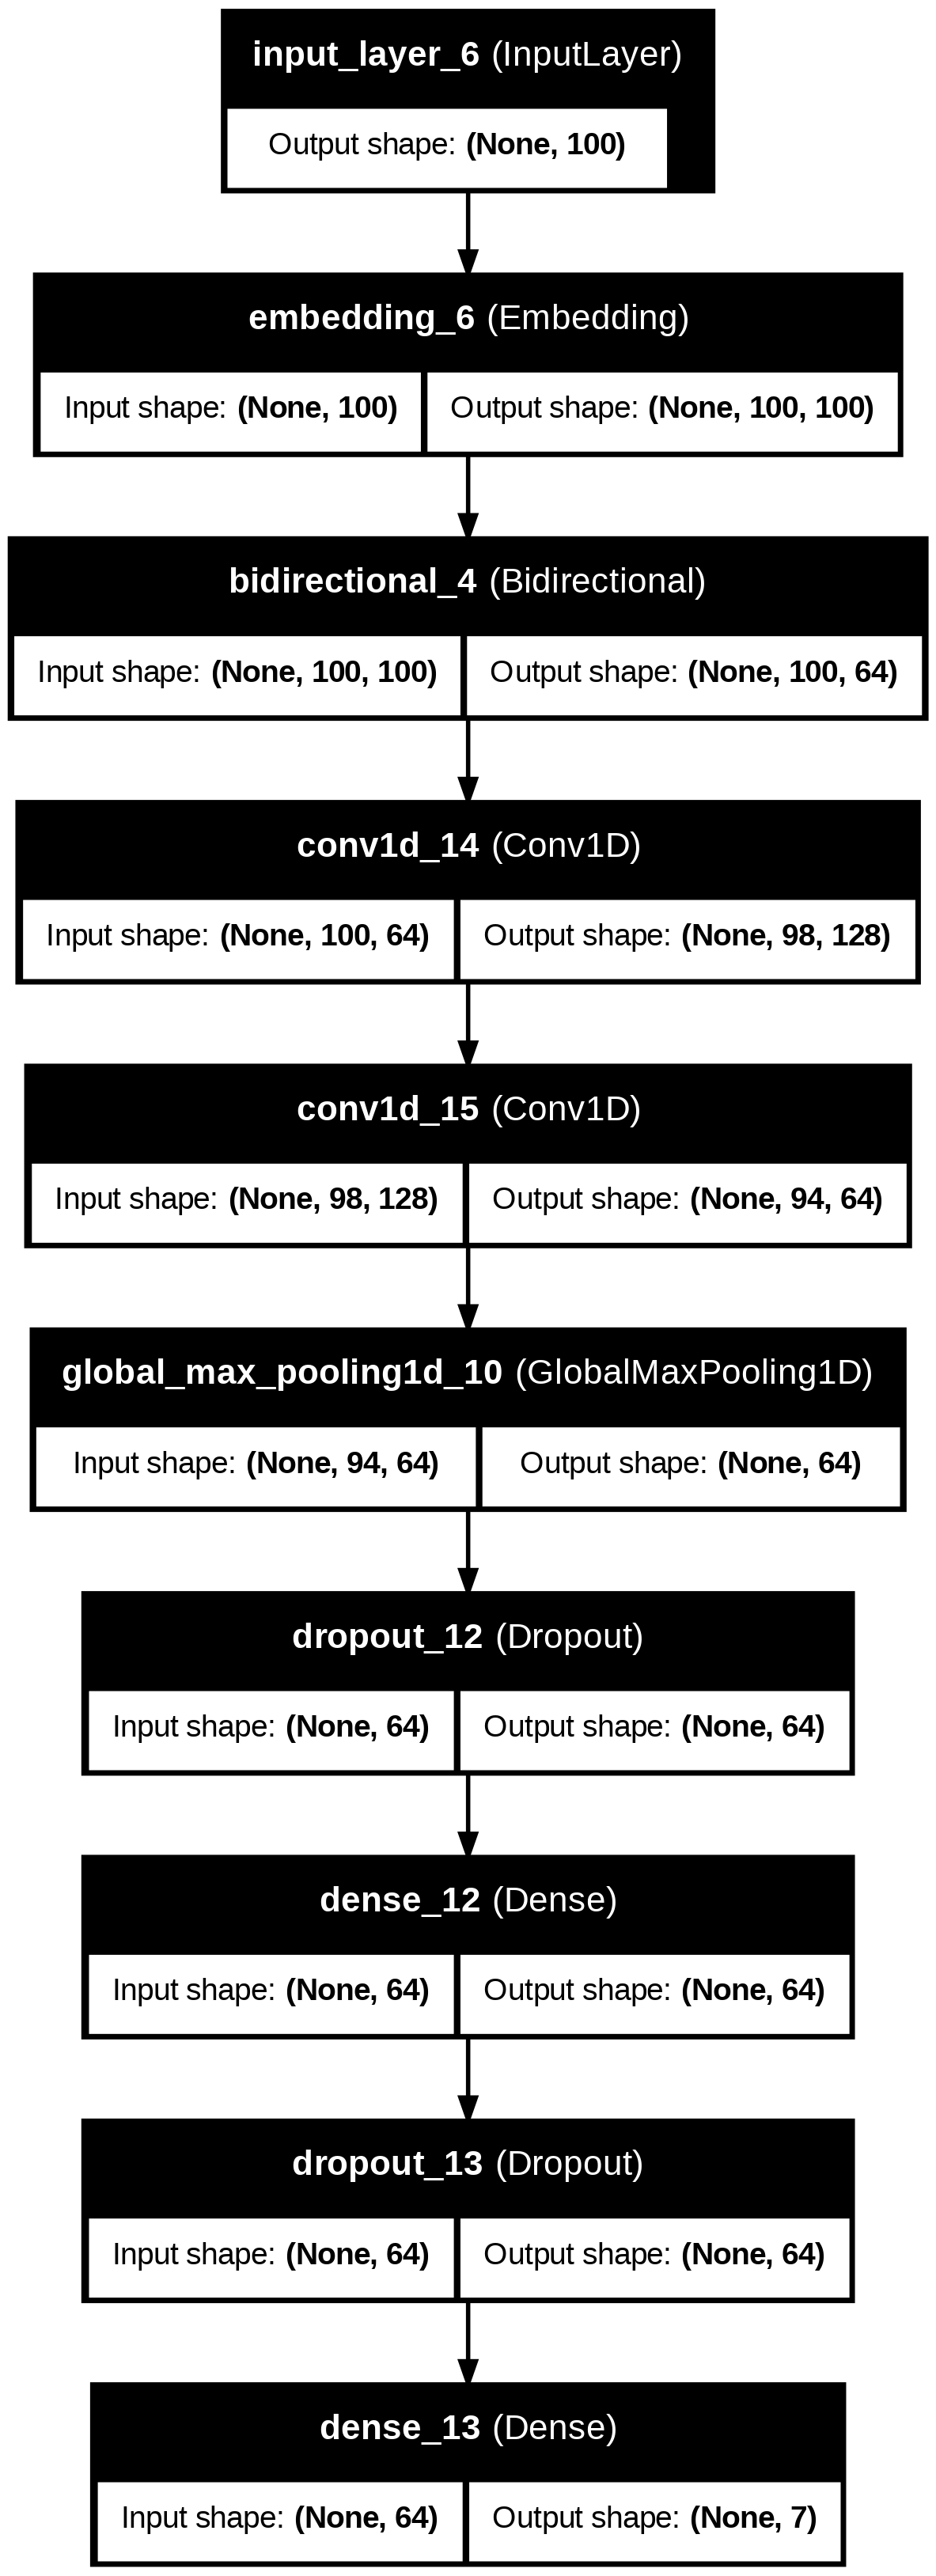

In [26]:
from keras.utils import plot_model
enhanced_model.summary()
plot_model(enhanced_model, show_shapes=True, show_layer_names=True)